# Employee Attrition study

Employee attrition is a serious problem for a company, maintining its top talents can lead to a great reduction in costs.

Given that the employee's productivity tends to diminish when they decide to leave the company and given that there's an overhead cost in replacing an employee and giving him the propper formation and time to adjust to the new position, it's safe to say that this is a costly event. Granted not all attritions are bad, some employees are just disrupting, but in general maintining the maximum number of employees as possible is a sound strategy, as described [here](https://inventiv.io/what-is-the-cost-of-replacing-an-employee/), [here](https://www.employeeconnect.com/blog/flight-risk-signals-what-makes-employees-leave/) and [here](http://analytics-magazine.org/predictive-analytics-the-privacy-pickle-hewlett-packards-prediction-of-employee-behavior/)

With this context in mind we'll try to create a model to predict who's about to leave the company so we could report it to HR and they can decid to do something about it

# Table Of Contents
 1. Exploratory Data Analysis
     - Checking for missing values
     - Creating some visualizations to get familiar with the data
 2. Feature Selection
 3. Modeling
 4. Interpreting results
     - Calculating total company costs reduction
     - Permuted feature importance
     - Partial dependence plots

In [1]:
# Loading required libraries
import eli5
import lime
import numpy as np
import pandas as pd
import seaborn as sns
import lime.lime_tabular
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score



# Loading the dataset
df = pd.read_csv("../input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")

print(df.shape)
df.head()

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Great! we got our dataset loaded, let's do a quick check to see how many missing values we're dealing with

In [2]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

It seems to be no missing values, which is perfect! we'll go ahead and get familiarized with the dataset

# 1. Exploratory data analysis
This section aims to explorate the data a bit, try to get a feel of the problem and maybe find some key insights that might be useful later on

First of all, lets let's just see the number of people who left and who didn't

In [3]:
# Create just a simple lambda to calculate the proportion of each group 
prop_func = lambda x: round(len(x) / df.shape[0], 5) * 100

df.groupby("Attrition")["Attrition"].agg(["count", prop_func])

,count,<lambda_0>
Attrition,,
No,1233,83.878
Yes,237,16.122


So we have 237 cases of employees who left the company which is around 16,122% of the entire dataset, this means that our classes are fairly **inbalanced**, so we'll see some ways to work around this issue

Let's continue with our analysis

## Whats the age distribution on each group?

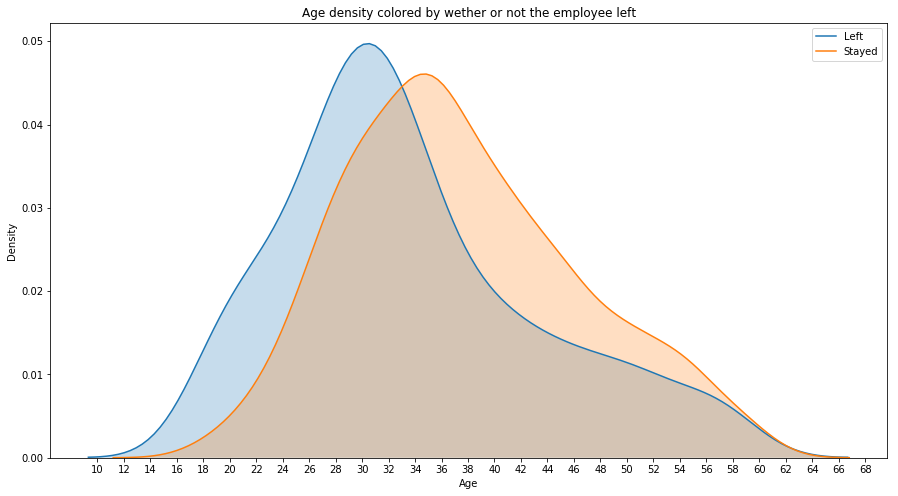

In [4]:
f,ax = plt.subplots(figsize=(15,8))
sns.kdeplot(df.loc[df.Attrition == "Yes", "Age"], shade = True, label = "Left")
sns.kdeplot(df.loc[df.Attrition == "No", "Age"], shade = True, label = "Stayed")
ax.set(xlabel = "Age", ylabel = "Density",title = "Age density colored by wether or not the employee left")
ax.set_xticks(range(10, 70, 2))
plt.show()

So it appears younger people tend to leave the company more often which is to be expected since they probably haven't settled on a house/family or they might get more job offerings. This feature is probably a good feature to use in our model

Note: don't worry there are no 10 year-olds working in this company, its just the way the kde plots this graph (:

## Which gender is more likely to leave?

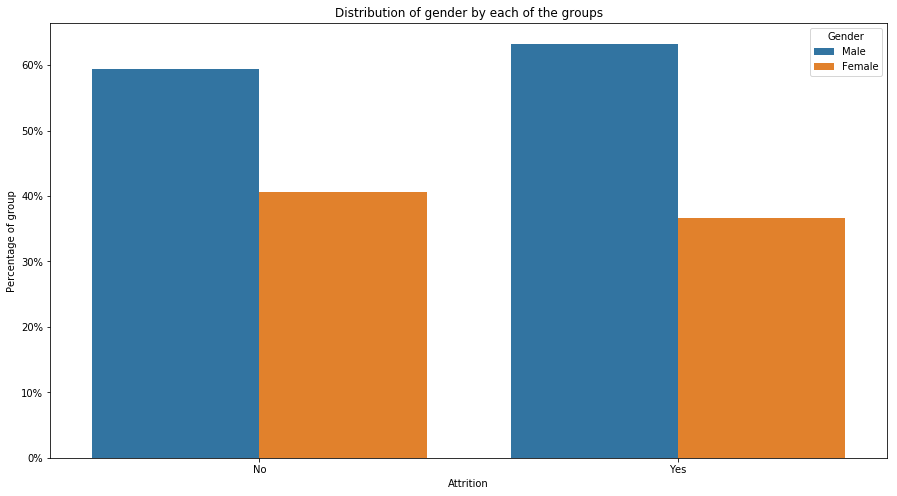

In [5]:
f,ax = plt.subplots(figsize=(15,8))

# Get the proportion of the genders grouped by the attrition status
grouped_data = df["Gender"].groupby(df["Attrition"]).value_counts(normalize = True).rename("Percentage of group").reset_index()

# Plot the result
sns.barplot(x = "Attrition", y = "Percentage of group", hue = "Gender", data = grouped_data)

# Convert y axis to percentage format
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set(title = "Distribution of gender by each of the groups")
plt.show()

This company has more men the women and so this plot shows us that men tend to leave the company more but only because they're in a larger number. This also indicates that gender might not be a key factor for employee attrition

## Are leavers more dissatisfied with their jobs?

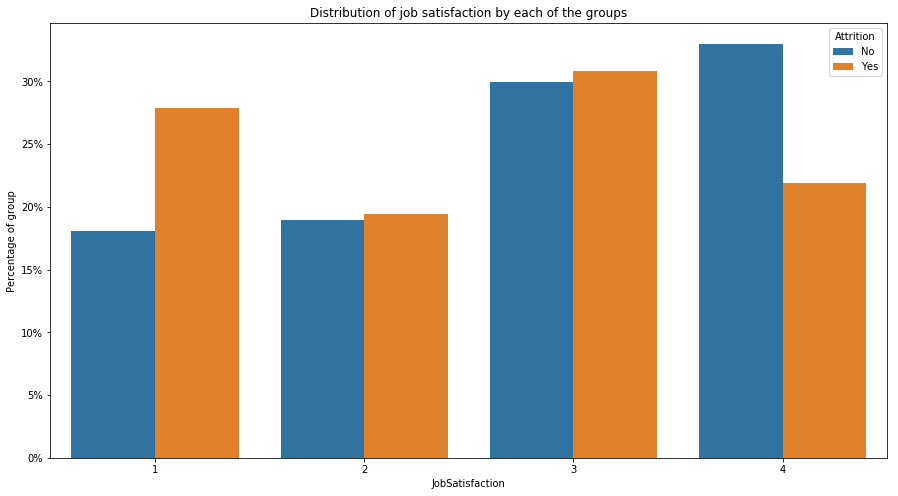

In [6]:
f,ax = plt.subplots(figsize=(15,8))
grouped_data = df["JobSatisfaction"].groupby(df["Attrition"]).value_counts(normalize = True).rename("Percentage of group").reset_index()
sns.barplot(x = "JobSatisfaction", y = "Percentage of group", hue = "Attrition", data = grouped_data)

# Convert y axis to percentage format
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set(title = "Distribution of job satisfaction by each of the groups")
plt.show()

It appears to be so. Around 27% of people who left the company felt really dissatisfied with their jobs, while only nearly 17% of people who stayed said the same thing.

In contrast people who stay in the company seem to be, in general, satisfied with their jobs.

It's also interesting to see there's a large portion of leavers that have a level 3 of satisfaction. This might be either because of the scoring mechanism (i.e, 3 is a somewhat neutral job statisfaction level) or they're cases where a person does not leave the job because they don't like it but maybe they received a better offer

## Do people who leave tend to have more overtime?

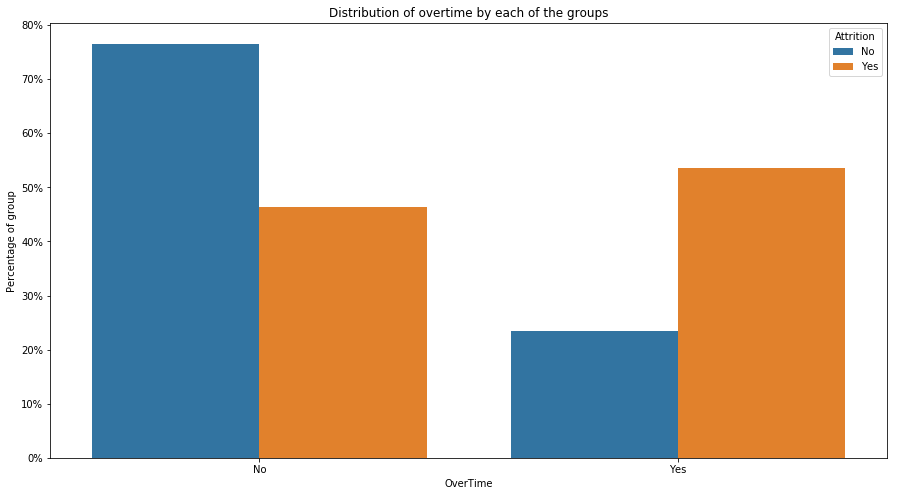

In [7]:
f,ax = plt.subplots(figsize=(15,8))
grouped_data = df["OverTime"].groupby(df["Attrition"]).value_counts(normalize = True).rename("Percentage of group").reset_index()
sns.barplot(x = "OverTime", y = "Percentage of group", hue = "Attrition", data = grouped_data)

# Convert y axis to percentage format
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set(title = "Distribution of overtime by each of the groups")
plt.show()

So there's a near 50-50 split in people who leave the company reagarding overtime, meaning some work overtime and some don't.

But the finding we can take from here is that just a small portion (around 27%) of people who stay in the company work overtime. Meaning this might be another usefull feature for our model, if an observation states that a person works overtime we'll be more inclined to say that this person is likely to leave the company (so go ahead and tell your bosses you're not working overtime because you don't want to leave the company (: )

There's many more plots we could make to answer some basic questions like these ones, but these visualizations are only one-dimensional (for each attrition group) so, although they're helpful, we might get some extra information when we see the relation between two or more variables

## Age vs monthly income with salary hike controling the size

This is a good company to be in since everyone got a increase in it's salary, but some received more than others, let's look at what's the relation between the age and the monthly income and let's make the points bigger where a person received a salary hike above the average (which is around 15%)

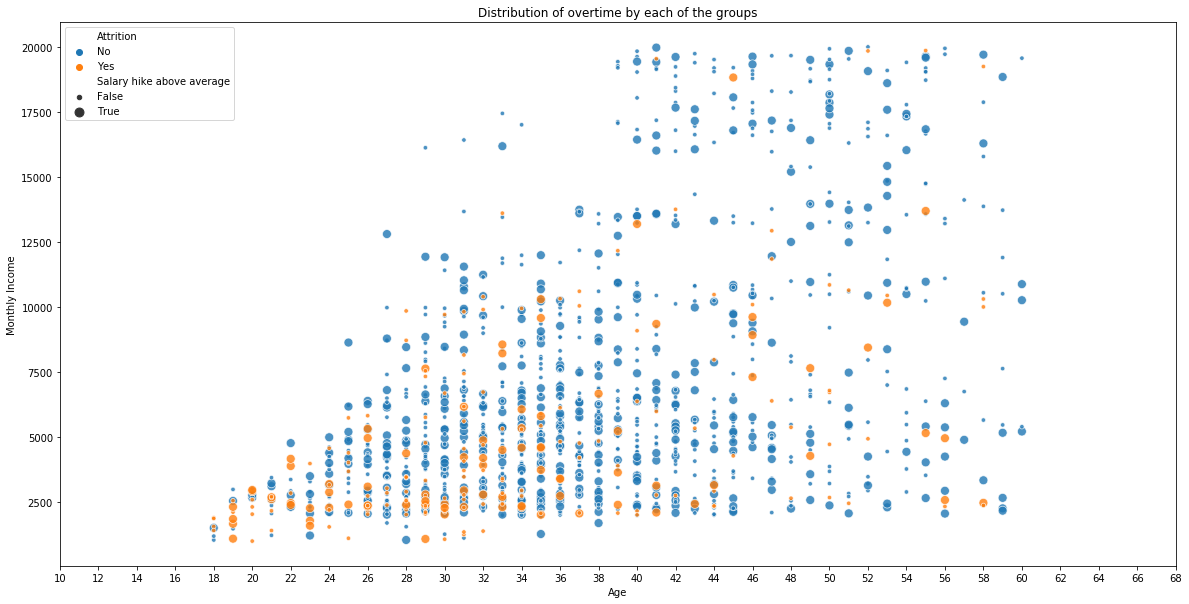

In [8]:
df["Salary hike above average"] = df.PercentSalaryHike > df.PercentSalaryHike.mean()

df_reordered = df.sort_values(by=['Attrition'])

f,ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x="Age", y="MonthlyIncome", hue="Attrition", size = "Salary hike above average", data=df_reordered, alpha = 0.8, sizes = (80,20))
ax.set(ylabel = "Monthly Income", title = "Distribution of overtime by each of the groups")
ax.set_xticks(range(10, 70, 2))
plt.show()

Okay so there's a lot of stuff here (maybe too much, ups) but lets break it down:

1. We can see that leavers are in the younger age group (as we saw before) but we actually see that they tend to have lower sallaries then persons who stayed in the company

2. As a person gets older they tend to get a higher monthly income (probably because their tenure in the company increases as well)

3. It appears that receiving a salary hike above the average has no effect on making a person stay in the company since the're so many leavers with above average salary hikes

4. This effect might only be noticeable for persons with higher monthly incomes (above 10000) but more investigation would be needed to say the for certain

lastly let's just see the overall correlation between the variables

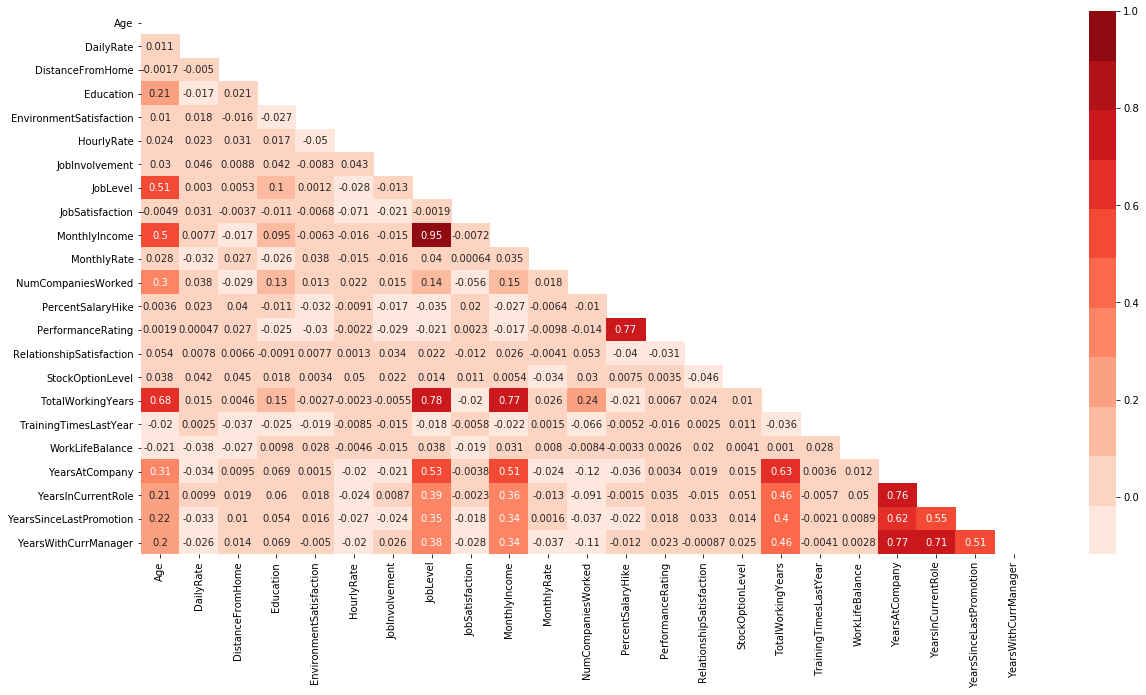

In [9]:
# I'm also removing these columns because they're either an ID or constant and have no variation
correlation = df.drop(["EmployeeCount", "EmployeeNumber", "StandardHours", "Salary hike above average"], axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(20,10))
sns.heatmap(correlation, annot = True, cmap = sns.color_palette("Reds", 11), mask = mask)
plt.show()

This heatmap says alot about the company:

1. Higher lob levels means higher monthly incomes (which is obvious)

2. Theres a strong correlation between the number of years at the company and the number of years with a given manager and role, meaning that people in this company don't often change managers/roles

3. People with higher performance ratings receive higher salary hikes (which is also obvious) but when we contrast this with the previous plot where we say there where a lot of leavers with above average salary hikes, we get the sense that many of our leavers are have a good performance, which aggravates the cost of employee attrition

Lets move on to a different analysis other than visualizations and let's which variables have a greater impact in our outcome variable through means of feature selection

# 2. Feature Selection

We'll be using a univariate filter. What this means is that for every variable we'll do a univariate statistical test and determine wether the variable is relevant to predict leaving employees or not. First we'll one-hot encode the necessary features and scale everything

Some features don't need to be one-hot encoded as they have a sense of order to them (like Education or  PerformanceRating) so we wount one-hot encode these features

In [10]:
#Lets deal with the categorical cloumns now
# simply change yes/no to 1/0 for Attrition, Gender, OverTime
df['Attrition'].replace({'No': 0, 'Yes': 1},inplace = True)
df['Gender'].replace({'Male': 0, 'Female': 1},inplace = True)
df['OverTime'].replace({'No': 0, 'Yes': 1},inplace = True)

# specifying names of categorical columns to be one-hot encoded
categorical_columns = ['BusinessTravel', 'Department', 'EducationField', "JobRole", "MaritalStatus"]

# transform the categorical columns
df = pd.get_dummies(df, columns=categorical_columns)

# Removing unecessary features
df.drop(["EmployeeNumber", "EmployeeCount", "Over18", "Salary hike above average", "StandardHours"], axis = 1, inplace = True)

df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,2,1,94,3,2,...,0,0,0,0,0,1,0,0,0,1
1,49,0,279,8,1,3,0,61,2,2,...,0,0,0,0,1,0,0,0,1,0
2,37,1,1373,2,2,4,0,92,2,1,...,1,0,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,4,1,56,3,1,...,0,0,0,0,1,0,0,0,1,0
4,27,0,591,2,1,1,0,40,3,1,...,1,0,0,0,0,0,0,0,1,0


In [11]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0.547619,1.0,0.715820,0.000000,0.25,0.333333,1.0,0.914286,0.666667,0.25,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.738095,0.0,0.126700,0.250000,0.00,0.666667,0.0,0.442857,0.333333,0.25,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.452381,1.0,0.909807,0.035714,0.25,1.000000,0.0,0.885714,0.333333,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.357143,0.0,0.923407,0.071429,0.75,1.000000,1.0,0.371429,0.666667,0.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.214286,0.0,0.350036,0.035714,0.00,0.000000,0.0,0.142857,0.666667,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


MinMaxScaler makes sure that every feature values ranges from 0 to 1 so that there's no discrepancy in the different feature scales, this scaler does not, however, handle outliers so that might be something we should watch out for and maybe correct with a different scaler, but I don't think it'll be worth the hassle.

Now that we have our features cleaned up we can perform our feature selection test

In [12]:
# specify our x and y variables
x, y = df.drop(["Attrition"], axis = 1), df.Attrition

# instantiate our selector to select the top 10 features
selector = SelectKBest(f_classif, k = 10)

# fit our selector to the data
x = pd.DataFrame(selector.fit_transform(x, y), index = x.index, columns = x.columns[selector.get_support(indices = True)])

# see what are the top selected features from our univariate filter
x.columns

Index(['Age', 'JobLevel', 'MonthlyIncome', 'OverTime', 'StockOptionLevel',
       'TotalWorkingYears', 'YearsInCurrentRole', 'YearsWithCurrManager',
       'JobRole_Sales Representative', 'MaritalStatus_Single'],
      dtype='object')

We previously saw that only a small portion of stayers actually worked overtime so it's no surprise it was selected.
The remaning features are pretty obvious to and one can hypothesize that a leaver is a person who works **OverTime** is **Single**, has spent alot of time in the same **Role** which is probably **Sales Representative**, probably hasn't worked in the company for very long and has a low **JobLevel**, has a lower **Age**, has no **StockOptionLevel** and has a lower **MonthlyIncome**. Of course this only of the top of my head but at least we have an ANOVA test to back our findings :)

Since we don't have many observations in our dataset, having too many features like we do might prove the learning process dificult, and so selecting features this way may be beneficial!

# 3. Modeling

We'll be modeling our that with stratified 5-Fold cross validation to try and minimize overfitting. We'll also leave 20% of our dataset for testing our final model. We're using stratified K-Foldto maintain the same proportion of observations in each class for every fold

In [13]:
# Splitting our total dataset so that we have 20% of it in the test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state = 888)

# Set the parameters by cross-validation
tuned_parameters = {
    "gamma" : [0.0001, 0.001, 0.1, 0.5, 1, 1.5, 2, 5, 7.5, 8, 10],
    "C": [0.0005, 0.001, 0.01, 0.1, 1, 8, 10, 100, 250, 500, 1000, 1500]
}

# Creating our support vector machine with class weights for maximizing balance between classes
estimator = SVC(class_weight = "balanced", kernel = "rbf")

# specifying the 5-fold cross validation
# With 5-fold cross validation we'll have 5 iterations where we train our model in 4 parts of the trainig set and validate it on the fifth-part
grid_searcher = GridSearchCV(estimator, tuned_parameters, cv = 5, scoring='roc_auc', verbose = 1)
# Trainig our model
grid_searcher.fit(x_train, y_train)
print(f"Best parameters set found on development set: \n{grid_searcher.best_params_}")

Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters set found on development set: 
{'C': 0.0005, 'gamma': 1}


[Parallel(n_jobs=1)]: Done 660 out of 660 | elapsed:   42.1s finished


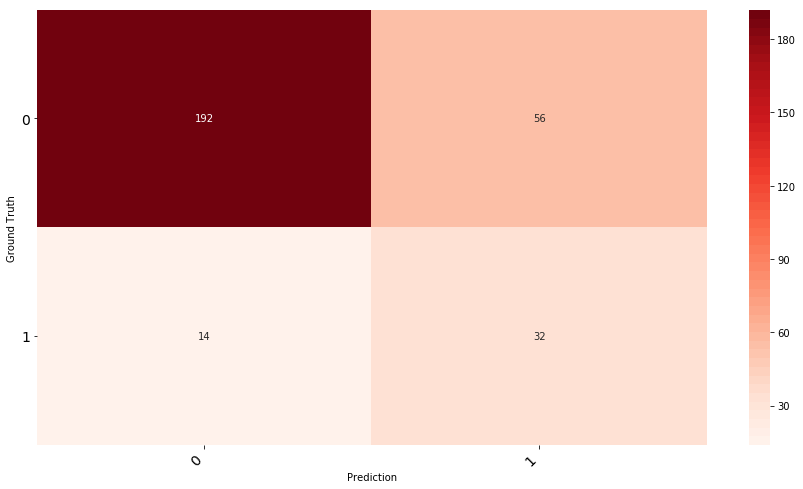

In [14]:
# Using grid_searcher best parameters
svm_classifier = SVC(class_weight = "balanced", C = 0.1, gamma = 1, kernel = "rbf", probability = True)
svm_classifier.fit(x_train, y_train)

# Predict our model on the test set
y_predicted = svm_classifier.predict(x_test)

fig = plt.figure(figsize=(15,8))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, y_predicted)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

In [15]:
print(f"""Accuray: {round(accuracy_score(y_test, y_predicted), 5) * 100}%
ROC-AUC: {round(roc_auc_score(y_test, y_predicted), 5) * 100}%""")
print(classification_report(y_test, y_predicted))

Accuray: 76.19%
ROC-AUC: 73.492%
              precision    recall  f1-score   support

         0.0       0.93      0.77      0.85       248
         1.0       0.36      0.70      0.48        46

    accuracy                           0.76       294
   macro avg       0.65      0.73      0.66       294
weighted avg       0.84      0.76      0.79       294



# 4. Interpreting the results

A [2012 study by the Center of American Progress](https://www.americanprogress.org/wp-content/uploads/2012/11/CostofTurnover.pdf) found that the median cost of replacing an employee was 21.4% of his/hers annual salary, we'll be using this value to calculate the cost we could have reducted if we had retained the employees we predicted of leaving in the test set

The study actually segmentates the cost percentage by how much an employee receives annualy but for the porpuse of this analysis the median is a good value to use

In [16]:
cost_percentage = 0.214

# I need to read the data again because we've already done standardization an we need to original values back to calculate the cost
df_unstanderdized = pd.read_csv("../input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# I'm selecting only the employees that were present in the test set
df_unstanderdized = df_unstanderdized.iloc[x_test.index, :]

df_unstanderdized["predicted_values"] = y_predicted

In [17]:
predicted_leavers = df_unstanderdized.loc[(df_unstanderdized.predicted_values == 1) & (df_unstanderdized.Attrition == "Yes"), :]

cost_reduction = predicted_leavers.apply(lambda row: (row.MonthlyIncome * 14) * cost_percentage, axis = 1)

In [18]:
print(f"The total ammount we could have saved this company is ${np.sum(cost_reduction)}!")

The total ammount we could have saved this company is $415614.108!


Our model is still far from production ready as it still has a some-what low precision, but if this company were to effectively retain all the true positives we identified in the test set (Which would be impossible because they we wouldn't know which ones where true-positives or false-positives, but regardless) the company could have saved **$415 614.108**! That's a good number to put in any results presentation you should to your management team :)!

# What makes the employees leave?

It's good to be able to save the company money by predicting who's going to leave and who's not, but the ideal situation is to inform the company what's the most critical features that make our model think that a person is going to leave.

To do that we'll dive a bit into machine learning explainability. We'll do this in three steps:

* Find out what are the features that the model payed close attetion to, using permutation feature importance

* From certain features let's check how is the model affect as they vary, using partial dependence plots

* Let's look at some people and see how did their features contribute to the decision of the model, using local permutation feature importance

## What are the most relevant features for our model?

To find this out we're going to be using permutation feature importance. This tecnhique is used after the model is trained and the idea is that we ask: **if I randomly shuffle a column of my validation data, how would that affect the accuracy of my model?**

In [19]:
perm = PermutationImportance(svm_classifier, random_state=1).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
0.0803 ± 0.0440,OverTime
0.0218 ± 0.0153,MaritalStatus_Single
0.0156 ± 0.0082,Age
0.0122 ± 0.0140,YearsWithCurrManager
0.0122 ± 0.0069,MonthlyIncome
0.0095 ± 0.0109,StockOptionLevel
0.0088 ± 0.0140,YearsInCurrentRole
0.0075 ± 0.0117,JobRole_Sales Representative
0.0054 ± 0.0092,TotalWorkingYears
0.0048 ± 0.0069,JobLevel


The results are:

* Overtime seems to be the most key factor for determining if a employee is likely to leave or not
* A person being single comes next
* Then comes the Age of the person followed by the number of years with their current manager as well as how much they're paid

So we can kind of have a feel of the type of person that leaves. Probably a young, single person who puts in alot of overtime, they may leave because they're the most attractive persons for other companies to employ them, or it might be because they're feeling unappreciated.

## But how does the effect of age/income evolve as these variables increase?

It's an interesting thing to find out. Do people tend to not leave as much as they get older? Do they stay if they have higher salaries?
To find this out we'll use partial dependence plots, which basically plot how the predicted probability changes as we increase a certain variable

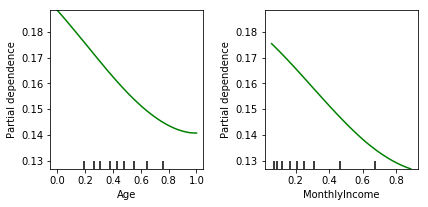

In [20]:
plot_partial_dependence(svm_classifier, x, [0, 2], feature_names = x.columns)

This plot shows us that as the Age of the employee and his/hers income increases, the probability of the employee leaving decreases (Age seems to increase the probability of an employee leaving after a certain high age).

## And what about other variables such as TotalWorkingYears and YearsInCurrentRole?

We can apply the same technique for these variables to answer this question

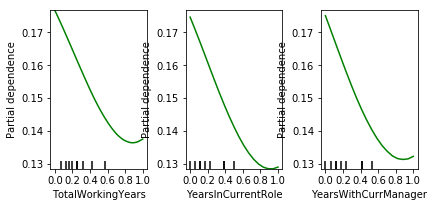

In [21]:
plot_partial_dependence(svm_classifier, x, [5, 6, 7], feature_names = x.columns)

Again we see a similar pattern, as these variables increase the predicted probability decreases and then slightly rises agin towards higher values

## How can we see the model decision process for each employee?

The previous analysis of feature importance were across all employees in the company, but how is the prediction for a single employee affected by his/hers features? To do this we need **local feature importance** and one way to do this is with [LIME (Local Importance Model-Agnostic Explanations)](https://arxiv.org/pdf/1602.04938)

The main idea behind LIME is that every complex model is linear at a local level. Therefore we can create a surrogate model that is more interpretable than our model, and draw our conclusions from it.

**Note:** It's very important that this analysis is done with caution, we might be tempted to change our features based on some examples we analyse but this might be a bad decision

Intercept 0.345840735047114
Prediction_local [0.18692442]
Right: 0.18863172815452378


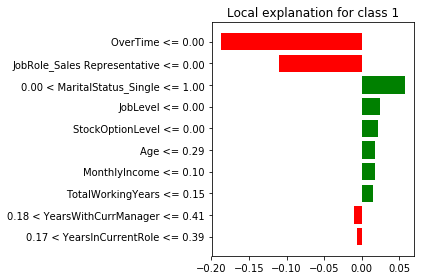

In [22]:
# Create an explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = x_train.values, feature_names = x_train.columns.values, discretize_continuous = True, mode = "classification", verbose = True, random_state = 888)

# Explain the first employee in the test set
exp = explainer.explain_instance(x_test.values[0,:], svm_classifier.predict_proba, num_features = x_test.shape[1])

#Plot local explanation
plt = exp.as_pyplot_figure()
plt.tight_layout()
exp.show_in_notebook(show_table = True)

This gives us alot of information about the prediction on this particular employee.

we see that the model gave him a 19% chance of leaving, and more importantly we can see which factors contribute the most for this decision.

- This particular employee has not worked overtime so this is a strong contradiction to the claim that the employee will leave the company
- This employee does not work as a Sales Representative so this is also a contradicting argument to the claim that the employee will leave
- He/She is single, is young and has a farely poor income with no stock options, and this makes the employee more likely to leave

We can do this process for every employee we want and have a better understanding of the feature importance vary from employee to employee.

I hope this helps you implement a similar concept in your company in order to save money, and especially, make everyone happier!

Cheers!